# Aim 
> Here we are aiming to predict connections between users. This will be based on comment karma, link_karma and average user upvotes in chatGPT subreddits

In [1]:
pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=03f439459b38730685913cfb3878baa0f38cac3f92d100dac36a9415fd752010
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


## Importing libraries

In [2]:
import pandas as pd 
import numpy as np
import collections

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv

from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling

import networkx as nx

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/vanderbilt/social/project')

Mounted at /content/drive


## Data munging

In [4]:
users = pd.read_csv("users.csv", header= None)
edges = pd.read_csv("edges.csv", header = None)
df = pd.read_csv("df.csv", index_col = 0)

In [5]:
users = users.reset_index()

In [6]:
users.columns = ["userid", 'username']

In [7]:
users

,userid,username
0,0,that_90s_guy
1,1,AutoModerator
2,2,scumbagdetector15
3,3,csch2
4,4,PlayerofVideoGames
...,...,...
608,608,Lanky_Information825
609,609,xebeka6808
610,610,HumanJenoM
611,611,mvandemar


In [8]:
df

,comment_karma,link_karma,avg_upvotes
that_90s_guy,31343.0,20684.0,1503.390000
AutoModerator,1000.0,1000.0,1.004695
scumbagdetector15,18369.0,1.0,170.600000
csch2,1981.0,2622.0,136.000000
PlayerofVideoGames,18476.0,473.0,57.000000
...,...,...,...
Lanky_Information825,326.0,3.0,5.000000
xebeka6808,4631.0,765.0,5.000000
HumanJenoM,8117.0,505.0,3.000000
mvandemar,4467.0,2391.0,2.000000


In [9]:
node_features = df[["comment_karma", "link_karma"]]
num_classes = 1

In [10]:
node_features

,comment_karma,link_karma
that_90s_guy,31343.0,20684.0
AutoModerator,1000.0,1000.0
scumbagdetector15,18369.0,1.0
csch2,1981.0,2622.0
PlayerofVideoGames,18476.0,473.0
...,...,...
Lanky_Information825,326.0,3.0
xebeka6808,4631.0,765.0
HumanJenoM,8117.0,505.0
mvandemar,4467.0,2391.0


In [11]:
# Convert to numpy
x = torch.tensor(node_features.values)
x.shape # [num_nodes x num_features]

torch.Size([613, 2])

In [12]:
df

,comment_karma,link_karma,avg_upvotes
that_90s_guy,31343.0,20684.0,1503.390000
AutoModerator,1000.0,1000.0,1.004695
scumbagdetector15,18369.0,1.0,170.600000
csch2,1981.0,2622.0,136.000000
PlayerofVideoGames,18476.0,473.0,57.000000
...,...,...,...
Lanky_Information825,326.0,3.0,5.000000
xebeka6808,4631.0,765.0,5.000000
HumanJenoM,8117.0,505.0,3.000000
mvandemar,4467.0,2391.0,2.000000


In [13]:
# y = torch.tensor(df.avg_upvotes, dtype=torch.float)
# y.shape

In [14]:
edges[['source', 'dest']] = edges[0].str.split("###", expand = True)

In [15]:
edges

,0,source,dest
0,AutoModerator###that_90s_guy,AutoModerator,that_90s_guy
1,scumbagdetector15###that_90s_guy,scumbagdetector15,that_90s_guy
2,csch2###scumbagdetector15,csch2,scumbagdetector15
3,scumbagdetector15###csch2,scumbagdetector15,csch2
4,PlayerofVideoGames###scumbagdetector15,PlayerofVideoGames,scumbagdetector15
...,...,...,...
1669,flossraptor###Alternative_Ad_9702,flossraptor,Alternative_Ad_9702
1670,Timofey_###Alternative_Ad_9702,Timofey_,Alternative_Ad_9702
1671,Alternative_Ad_9702###Alternative_Ad_9702,Alternative_Ad_9702,Alternative_Ad_9702
1672,xebeka6808###Alternative_Ad_9702,xebeka6808,Alternative_Ad_9702


In [16]:
edges = edges[['source', 'dest']]

In [17]:
edges['source']

0             AutoModerator
1         scumbagdetector15
2                     csch2
3         scumbagdetector15
4        PlayerofVideoGames
               ...         
1669            flossraptor
1670               Timofey_
1671    Alternative_Ad_9702
1672             xebeka6808
1673             xebeka6808
Name: source, Length: 1674, dtype: object

In [18]:
# Perform merge to obtain the edges from users and movies:
edges_source_id = pd.merge(edges['source'], users,
                            left_on='source', right_on='username', how='left')

In [19]:
users

,userid,username
0,0,that_90s_guy
1,1,AutoModerator
2,2,scumbagdetector15
3,3,csch2
4,4,PlayerofVideoGames
...,...,...
608,608,Lanky_Information825
609,609,xebeka6808
610,610,HumanJenoM
611,611,mvandemar


In [20]:
edges_source_id = torch.from_numpy(edges_source_id['userid'].values)

In [21]:
edges_source_id

tensor([  1,   2,   3,  ..., 606, 609, 609])

In [22]:
edges_dest_id = pd.merge(edges['dest'], users,
                            left_on='dest', right_on='username', how='left')
edges_dest_id = torch.from_numpy(edges_dest_id['userid'].values)


In [23]:
edges_dest_id

tensor([  0,   0,   2,  ..., 606, 606, 606])

In [24]:
# # With this, we are ready to construct our `edge_index` in COO format
# # following PyG semantics:
edge_source_dest = torch.stack([edges_source_id, edges_dest_id], dim=0)


In [25]:
x = torch.tensor(x.float())
# y = torch.tensor(y).ravel()

<ipython-input-25-d28a0899863e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x.float())


In [26]:
# y.shape

## Graph creation

In [28]:
data = Data(x= x , edge_index=edge_source_dest, num_classes = num_classes)

In [29]:
data

Data(x=[613, 2], edge_index=[2, 1674], num_classes=1)

## setting seeds

In [30]:
import random

import numpy as np
from torch_geometric.seed import seed_everything
seed_everything(4)

## Link prediction

In [31]:
transform = T.Compose([
    T.NormalizeFeatures(),
    # T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.1, num_test=0.15, is_undirected=True,
                      add_negative_train_samples=False),
])

In [32]:
data = transform(data)

In [33]:
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = data

In [34]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Define two graph convolutional layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        # Apply first convolutional layer followed by ReLU activation function
        x = self.conv1(x, edge_index).relu()
        # Apply second convolutional layer and return encoded node features
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        # Use encoded node features to compute probability of an edge
        # by taking elementwise multiplication of the feature vectors of
        # the nodes connected by the edge, and then summing over the feature dimensions
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        # Compute the complete adjacency matrix using the encoded node features
        prob_adj = z @ z.t()
        # Find the indices of non-zero entries in the adjacency matrix
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [35]:
model = Net(train_data.num_node_features, 128, 64)#.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
# In link prediction tasks, the model aims to predict whether an edge exists between two nodes in a graph. 
# The output of the model is a single value between 0 and 1, representing the probability that an edge exists
#  between the two nodes. In this case, BCEWithLogitsLoss (binary cross-entropy with logits) is commonly used as the loss function, 
# because it can handle the binary nature of the problem and the fact that the output is a continuous value that needs to be thresholded
#  to obtain binary predictions. 
loss_values = []
def train():
    model.train()
    optimizer.zero_grad()
 # Encode the node features to obtain the latent representation of the nodes
    z = model.encode(train_data.x, train_data.edge_index)

    # Perform negative sampling to obtain negative edge samples
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')
        # sparse for performance reasons 

    # Concatenate the positive and negative edge samples
    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    
    # Concatenate the labels for the positive and negative edge samples
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    # Decode the latent representations to obtain the predicted probabilities of the edges
    out = model.decode(z, edge_label_index).view(-1)
    
    # Calculate the loss using binary cross-entropy with logits
    loss = criterion(out, edge_label)
    
    # Append the loss value to the loss history list
    loss_values.append(loss.item())
    
    # Compute gradients and update the model weights
    loss.backward()
    optimizer.step()
    
    # Return the loss value for this iteration
    return loss
    
@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
#    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
 #       final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, ')
#          f'Test: {test_auc:.4f}')

# print(f'Final Test: {final_test_auc:.4f}')
print(f'Best val auc: {best_val_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6587, Val: 0.8073, 
Epoch: 002, Loss: 0.6468, Val: 0.8009, 
Epoch: 003, Loss: 0.6252, Val: 0.7766, 
Epoch: 004, Loss: 0.6189, Val: 0.7677, 
Epoch: 005, Loss: 0.6127, Val: 0.7557, 
Epoch: 006, Loss: 0.6074, Val: 0.7250, 
Epoch: 007, Loss: 0.5837, Val: 0.6869, 
Epoch: 008, Loss: 0.5826, Val: 0.6883, 
Epoch: 009, Loss: 0.5956, Val: 0.6962, 
Epoch: 010, Loss: 0.5720, Val: 0.7032, 
Epoch: 011, Loss: 0.5682, Val: 0.7238, 
Epoch: 012, Loss: 0.5732, Val: 0.7340, 
Epoch: 013, Loss: 0.5667, Val: 0.7540, 
Epoch: 014, Loss: 0.5702, Val: 0.7842, 
Epoch: 015, Loss: 0.5701, Val: 0.7956, 
Epoch: 016, Loss: 0.5696, Val: 0.8014, 
Epoch: 017, Loss: 0.5637, Val: 0.8179, 
Epoch: 018, Loss: 0.5576, Val: 0.8025, 
Epoch: 019, Loss: 0.5490, Val: 0.7903, 
Epoch: 020, Loss: 0.5454, Val: 0.7965, 
Epoch: 021, Loss: 0.5427, Val: 0.7900, 
Epoch: 022, Loss: 0.5399, Val: 0.7601, 
Epoch: 023, Loss: 0.5499, Val: 0.7962, 
Epoch: 024, Loss: 0.5478, Val: 0.8109, 
Epoch: 025, Loss: 0.5483, Val: 0.7636, 


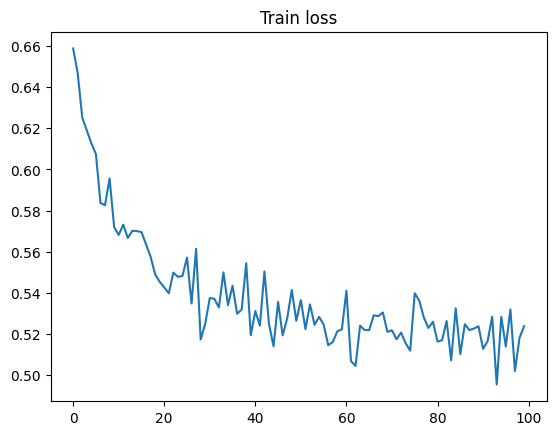

In [36]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.title("Train loss");

### Hyperparameter tuning  

- Number of layers:  1, 2, and also 5
- L2 regularization on the neural network weight matrices/parameters
(i.e., weight decay parameter: 0, 1e-4, and 1e-2)
- Learning rate given as input to torch.optim.Adam(): 1e-5 and 1e-2

I will calculate the mean and standard deviation of 3 runs 

#### 2 layers implemenation

In [37]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super().__init__()
        # Define two graph convolutional layers
        self.conv1 = GCNConv(in_channels, hidden_channels, dropout = dropout)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def encode(self, x, edge_index):
        # Apply first convolutional layer followed by ReLU activation function
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, training=self.training, p=self.dropout)
        # Apply second convolutional layer and return encoded node features
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        # Use encoded node features to compute probability of an edge
        # by taking elementwise multiplication of the feature vectors of
        # the nodes connected by the edge, and then summing over the feature dimensions
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        # Compute the complete adjacency matrix using the encoded node features
        prob_adj = z @ z.t()
        # Find the indices of non-zero entries in the adjacency matrix
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [38]:
# In link prediction tasks, the model aims to predict whether an edge exists between two nodes in a graph. 
# The output of the model is a single value between 0 and 1, representing the probability that an edge exists
#  between the two nodes. In this case, BCEWithLogitsLoss (binary cross-entropy with logits) is commonly used as the loss function, 
# because it can handle the binary nature of the problem and the fact that the output is a continuous value that needs to be thresholded
#  to obtain binary predictions. 
loss_values = []
def train():
    model.train()
    optimizer.zero_grad()
 # Encode the node features to obtain the latent representation of the nodes
    z = model.encode(train_data.x, train_data.edge_index)

    # Perform negative sampling to obtain negative edge samples
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')
        # sparse for performance reasons 

    # Concatenate the positive and negative edge samples
    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    
    # Concatenate the labels for the positive and negative edge samples
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    # Decode the latent representations to obtain the predicted probabilities of the edges
    out = model.decode(z, edge_label_index).view(-1)
    
    # Calculate the loss using binary cross-entropy with logits
    loss = criterion(out, edge_label)
    
    # Append the loss value to the loss history list
    loss_values.append(loss.item())
    
    # Compute gradients and update the model weights
    loss.backward()
    optimizer.step()
    
    # Return the loss value for this iteration
    return loss
    
@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
#    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
 #       final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, ')
#          f'Test: {test_auc:.4f}')

# print(f'Final Test: {final_test_auc:.4f}')
print(f'Best val auc: {best_val_auc:.4f}')


Epoch: 001, Loss: 0.5066, Val: 0.7924, 
Epoch: 002, Loss: 0.5194, Val: 0.7921, 
Epoch: 003, Loss: 0.5232, Val: 0.7717, 
Epoch: 004, Loss: 0.5241, Val: 0.7866, 
Epoch: 005, Loss: 0.5150, Val: 0.7952, 
Epoch: 006, Loss: 0.5250, Val: 0.7700, 
Epoch: 007, Loss: 0.5249, Val: 0.7500, 
Epoch: 008, Loss: 0.5341, Val: 0.7798, 
Epoch: 009, Loss: 0.5143, Val: 0.8031, 
Epoch: 010, Loss: 0.5233, Val: 0.7764, 
Epoch: 011, Loss: 0.5179, Val: 0.7503, 
Epoch: 012, Loss: 0.5193, Val: 0.7880, 
Epoch: 013, Loss: 0.5252, Val: 0.7907, 
Epoch: 014, Loss: 0.5308, Val: 0.7630, 
Epoch: 015, Loss: 0.5096, Val: 0.7528, 
Epoch: 016, Loss: 0.5217, Val: 0.7929, 
Epoch: 017, Loss: 0.5155, Val: 0.8025, 
Epoch: 018, Loss: 0.5243, Val: 0.7804, 
Epoch: 019, Loss: 0.5107, Val: 0.7519, 
Epoch: 020, Loss: 0.5221, Val: 0.7779, 
Epoch: 021, Loss: 0.5134, Val: 0.7982, 
Epoch: 022, Loss: 0.5084, Val: 0.7881, 
Epoch: 023, Loss: 0.5178, Val: 0.7566, 
Epoch: 024, Loss: 0.5298, Val: 0.7548, 
Epoch: 025, Loss: 0.5150, Val: 0.7776, 


In [39]:
# Define the ranges for each hyperparameter
weight_decays = [0, 1e-4, 1e-2] 
learning_rates = [1e-5, 1e-2]
dropout_rates = [0, 0.2, 0.4, 0.6]

# Define the number of times to repeat for each set of hyperparameters
num_repeats = 3

# Initialize a dictionary to store the results
results = {}

# Loop over all possible combinations of hyperparameters
for weight_decay in weight_decays:
      for learning_rate in learning_rates:
          for dropout_rate in dropout_rates:

            val_auc_list = []
            for repeat in range(num_repeats):

              model = Net(train_data.num_node_features, 128, 64, dropout = dropout_rate)#.to(device)
              optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay = weight_decay)

              best_val_auc = final_test_auc = 0
              for epoch in range(1, 101):
                  loss = train()
                  val_auc = test(val_data)
                  if val_auc > best_val_auc:
                      best_val_auc = val_auc
                  # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f} ')

              # print(f'Best val auc: {best_val_auc:.4f}')
              val_auc_list.append(best_val_auc)

            # Calculate the mean and standard deviation of accuracy for the current hyperparameters
            auc_mean = round(np.mean(val_auc_list),4)
            auc_std = round(np.std(val_auc_list),4)
            
            # Store the results in the dictionary
            results[(weight_decay,learning_rate, dropout_rate)] = (auc_mean, auc_std)


In [40]:
results

{(0, 1e-05, 0): (0.727, 0.0136),
 (0, 1e-05, 0.2): (0.7049, 0.0253),
 (0, 1e-05, 0.4): (0.7015, 0.0124),
 (0, 1e-05, 0.6): (0.7263, 0.0126),
 (0, 0.01, 0): (0.818, 0.0047),
 (0, 0.01, 0.2): (0.8228, 0.006),
 (0, 0.01, 0.4): (0.8253, 0.0044),
 (0, 0.01, 0.6): (0.8187, 0.008),
 (0.0001, 1e-05, 0): (0.7055, 0.0113),
 (0.0001, 1e-05, 0.2): (0.6914, 0.0054),
 (0.0001, 1e-05, 0.4): (0.731, 0.0152),
 (0.0001, 1e-05, 0.6): (0.717, 0.0246),
 (0.0001, 0.01, 0): (0.8172, 0.0045),
 (0.0001, 0.01, 0.2): (0.8287, 0.0051),
 (0.0001, 0.01, 0.4): (0.8242, 0.0024),
 (0.0001, 0.01, 0.6): (0.8212, 0.0052),
 (0.01, 1e-05, 0): (0.724, 0.0165),
 (0.01, 1e-05, 0.2): (0.726, 0.0125),
 (0.01, 1e-05, 0.4): (0.7396, 0.0039),
 (0.01, 1e-05, 0.6): (0.727, 0.011),
 (0.01, 0.01, 0): (0.8206, 0.0056),
 (0.01, 0.01, 0.2): (0.8234, 0.008),
 (0.01, 0.01, 0.4): (0.8289, 0.0021),
 (0.01, 0.01, 0.6): (0.8259, 0.0021)}

#### Adding all results to a table

In [41]:
df = pd.DataFrame.from_dict(results, orient='index')

df.reset_index(inplace = True)

df.columns = ['WD_LR_dropout', 'auc_mean', 'auc_std_dev']
df.sort_values("auc_mean", ascending = False)


,WD_LR_dropout,auc_mean,auc_std_dev
22,"(0.01, 0.01, 0.4)",0.8289,0.0021
13,"(0.0001, 0.01, 0.2)",0.8287,0.0051
23,"(0.01, 0.01, 0.6)",0.8259,0.0021
6,"(0, 0.01, 0.4)",0.8253,0.0044
14,"(0.0001, 0.01, 0.4)",0.8242,0.0024
21,"(0.01, 0.01, 0.2)",0.8234,0.0080
5,"(0, 0.01, 0.2)",0.8228,0.0060
15,"(0.0001, 0.01, 0.6)",0.8212,0.0052
20,"(0.01, 0.01, 0)",0.8206,0.0056
7,"(0, 0.01, 0.6)",0.8187,0.0080


Best performance is for weight decay of 0.01, a learning rate of 0.01 and a dropout rate of 0.4.

## Evaluate on the test set 

In [42]:
model = Net(train_data.num_node_features, 128, 64, dropout = 0.4)#.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay = 0.01)

best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    test_auc = test(test_data)
    if test_auc > final_test_auc:
        final_test_auc = test_auc
    # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')
print(f'Final Test: {final_test_auc:.4f}')


Final Test: 0.8771


## References

Link Regression on Movielens.ipynb - Colaboratory
https://colab.research.google.com/drive/1N3LvAO0AXV4kBPbTMX866OwJM9YS6Ji2?usp=sharing#scrollTo=_5_rbeCjJnsz  (useful for the loss function and metric)